In [1]:
import re
import traceback
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, length, concat_ws, regexp_replace, size, split, array_contains, expr, array_distinct, array_remove
from pyspark.sql.types import StringType, IntegerType, DoubleType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer,
    VectorAssembler, NGram, Word2Vec
)
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = (SparkSession.builder
    .appName("GPU_Optimized_RAPIDS")
    .master("local[*]")
    .config("spark.driver.memory","24g")
    .config("spark.executor.memory", "24g")
    .config("spark.executor.cores", "4")
    .config("spark.driver.cores", "4")
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.plugins", "com.nvidia.spark.SQLPlugin")
    .config("spark.driver.host", "localhost")
    .config("spark.rapids.sql.explain", "ALL")
    .config("spark.rapids.sql.allowMultipleJars", "ALWAYS")
    .config("spark.rapids.sql.enabled", "true")
    .config("spark.rapids.memory.hostStorageFraction", "0.8")
    .config("spark.rapids.memory.deviceStorageFraction", "0.8")
    .config("spark.rapids.sql.concurrentGpuTasks", "2")
    .config("spark.memory.offHeap.enabled", "true")
    .config("spark.memory.offHeap.size", "8g")
    .config("spark.rapids.memory.gpu.allocation.limit", "0.9")
    .config("spark.rapids.host.shim.async", "true")
    .config("spark.sql.session.timeZone", "UTC")
    .config("spark.rapids.sql.exec.CollectLimitExec", "true")
    .config("spark.sql.inMemoryColumnarStorage.batchSerializer", "com.nvidia.spark.rapids.shims.SparkShimServiceProvider")
    .getOrCreate()
)

data_path = "/mnt/c/Users/BerenÜnveren/Desktop/BIL401/data/train.csv"

try:
    print("--- Data Loading ---")
    start_load_time = time.time()
    df = spark.read.format("csv") \
        .option("header", "true") \
        .option("quote", "\"") \
        .option("multiLine", "true") \
        .option("inferSchema", "true") \
        .load(data_path)
    load_time = time.time() - start_load_time
    print(f"Data load time: {load_time:.2f} seconds")
    print("data schema:")
    df.printSchema()
    print("Y column distribution after load (should be HQ, LQ_EDIT, LQ_CLOSE):")
    df.groupBy("Y").count().show()

    print("--- Data Cleaning and Feature Engineering (initial steps) ---")
    start_clean_feature_time = time.time()
    df_clean = df.na.drop(subset=["Title", "Body", "Tags", "Y"]) \
        .withColumn("CleanBody", regexp_replace(col("Body"), "<.*?>", "")) \
        .withColumn("text", concat_ws(" ", col("Title"), col("CleanBody")))

    df_clean = df_clean.withColumn("tags_list", split(expr("TRIM(REPLACE(REPLACE(Tags, '<', ' '), '>', ' '))")," "))

    # Optional: Remove empty strings from tags_list if they are problematic for downstream stages.
    # This *might* require a UDF if the array functions available in Spark SQL are not sufficient
    # to filter based on string length within arrays without breaking GPU offload.
    # For HashingTF, empty strings are often handled gracefully, so this might not be needed.
    # For this example, we'll keep it simple to maximize GPU, assuming HashingTF can handle them.
    # If not, a complex SQL expression or a small CPU fallback for this specific step might be unavoidable.
    # df_clean = df_clean.withColumn("tags_list", array_remove(col("tags_list"), ""))


    df_featured = df_clean.withColumn("title_len", length(col("Title"))) \
        .withColumn("body_len", length(col("CleanBody"))) \
        .withColumn("punct_count", length(regexp_replace(col("text"), "[?!]", ""))) \
        .withColumn("avg_word_len", col("text").cast(StringType()).cast(DoubleType()) / (size(split(col("text"), " ")) + 1e-6))
    df_featured = df_clean.withColumn("title_len", length(col("Title"))) \
        .withColumn("body_len", length(col("CleanBody"))) \
        .withColumn("punct_count", length(regexp_replace(col("text"), "[?!]", ""))) \
        .withColumn("avg_word_len", 
                    length(regexp_replace(col("text"), " ", "")).cast(DoubleType()) / \
                    (size(split(col("text"), " ")) + 1e-6))


    clean_feature_time = time.time() - start_clean_feature_time
    print(f"Initial data cleaning and feature engineering time: {clean_feature_time:.2f} seconds")

    label_indexer = StringIndexer(inputCol="Y", outputCol="label", handleInvalid="skip")

    stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    ngram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")

    hashing_tf_text = HashingTF(inputCol="filtered_words", outputCol="raw_text_features", numFeatures=20000)
    idf_text = IDF(inputCol="raw_text_features", outputCol="text_features")

    hashing_tf_bigrams = HashingTF(inputCol="bigrams", outputCol="raw_bigrams_features", numFeatures=20000)
    idf_bigrams = IDF(inputCol="raw_bigrams_features", outputCol="bigrams_features")

    w2v = Word2Vec(vectorSize=100, minCount=5, inputCol="filtered_words", outputCol="w2v_features")

    hashing_tf_tags = HashingTF(inputCol="tags_list", outputCol="raw_tags_features", numFeatures=5000)
    idf_tags = IDF(inputCol="raw_tags_features", outputCol="tags_tags")

    feature_assembler = VectorAssembler(
        inputCols=["text_features", "bigrams_features", "w2v_features", "tags_tags",
                   "title_len", "body_len", "punct_count", "avg_word_len"],
        outputCol="features"
    )

    df_processed = df_featured.withColumn("words", split(col("text"), " "))
    (train_data, test_data) = df_processed.randomSplit([0.8, 0.2], seed=42)

    train_data.cache()
    test_data.cache()
    train_data.count()
    test_data.count()
    
    print(f"Train data count: {train_data.count()}, Test data count: {test_data.count()}")

    print("\n--- Logistic Regression Training ---")
    lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
    lr_pipeline = Pipeline(stages=[
        label_indexer,
        stopwords_remover,
        ngram,
        hashing_tf_text, idf_text, hashing_tf_bigrams, idf_bigrams, w2v, hashing_tf_tags, idf_tags,
        feature_assembler, lr
    ])

    start_lr_train_time = time.time()
    lr_model = lr_pipeline.fit(train_data)
    lr_train_time = time.time() - start_lr_train_time
    print(f"Logistic Regression training time: {lr_train_time:.2f} seconds")

    start_lr_predict_time = time.time()
    lr_predictions = lr_model.transform(test_data)
    lr_predict_time = time.time() - start_lr_predict_time
    print(f"Logistic Regression prediction time: {lr_predict_time:.2f} seconds")

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    accuracy_lr = evaluator.setMetricName("accuracy").evaluate(lr_predictions)
    f1_score_lr = evaluator.setMetricName("f1").evaluate(lr_predictions)

    print("\nLogistic Regression Results:")
    print(f"Accuracy: {accuracy_lr:.4f}")
    print(f"F1 Score: {f1_score_lr:.4f}")
    print("Confusion Matrix:")
    lr_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()

except Exception as e:
    print(f"An error occurred: {e}")
    traceback.print_exc()

25/08/08 14:12:54 WARN Utils: Your hostname, DESKTOP-15VE119 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/08/08 14:12:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/08 14:12:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/08/08 14:12:57 WARN RapidsPluginUtils: RAPIDS Accelerator 24.02.0 using cudf 24.02.1.
25/08/08 14:12:57 WARN RapidsPluginUtils: spark.rapids.sql.multiThreadedRead.numThreads is set to 20.
25/08/08 14:12:57 WARN RapidsPluginUtils: Multiple cudf jars found in the classpath:
revison: dd34fdbe35e68ba56a2183f11ed822ddaa6c927b
	jar URL: jar:file:/home/bunveren/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/pyspark/jars/rapids-4-spark_2.12-24.02.0.jar
	version=24.02.1
	user=
	

--- Data Loading ---


Data load time: 7.01 seconds
data schema:
root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Body: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- Y: string (nullable = true)

Y column distribution after load (should be HQ, LQ_EDIT, LQ_CLOSE):


25/08/08 14:13:19 WARN GpuOverrides: 
*Exec <CollectLimitExec> will run on GPU
  *Partitioning <SinglePartition$> will run on GPU
  *Exec <HashAggregateExec> will run on GPU
    *Expression <AggregateExpression> count(1) will run on GPU
      *Expression <Count> count(1) will run on GPU
    *Expression <Alias> cast(count(1)#18L as string) AS count#26 will run on GPU
      *Expression <Cast> cast(count(1)#18L as string) will run on GPU
    *Exec <ShuffleExchangeExec> will run on GPU
      *Partitioning <HashPartitioning> will run on GPU
      *Exec <HashAggregateExec> will run on GPU
        *Expression <AggregateExpression> partial_count(1) will run on GPU
          *Expression <Count> count(1) will run on GPU
        *Exec <FileSourceScanExec> will run on GPU

25/08/08 14:13:20 WARN GpuOverrides: 
*Exec <CollectLimitExec> will run on GPU
  *Partitioning <SinglePartition$> will run on GPU
  *Exec <HashAggregateExec> will run on GPU
    *Expression <AggregateExpression> count(1) will ru

+--------+-----+
|       Y|count|
+--------+-----+
|LQ_CLOSE|15000|
|      HQ|15000|
| LQ_EDIT|15000|
+--------+-----+

--- Data Cleaning and Feature Engineering (initial steps) ---
Initial data cleaning and feature engineering time: 0.39 seconds


25/08/08 14:13:24 WARN GpuOverrides: 
*Exec <SampleExec> will run on GPU
  *Exec <SortExec> will run on GPU
    *Expression <SortOrder> Id#0 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> Title#1 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> Body#2 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> Tags#3 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> CreationDate#4 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> Y#5 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> CleanBody#58 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> text#66 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> tags_list#75 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> title_len#135 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> body_len#146 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> punct_count#158 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> avg_word_len#171 ASC 

Train data count: 35997, Test data count: 9003

--- Logistic Regression Training ---


25/08/08 14:13:36 WARN GpuOverrides: 
!Exec <ObjectHashAggregateExec> cannot run on GPU because not all expressions can be replaced
  @Expression <AggregateExpression> stringindexeraggregator(org.apache.spark.ml.feature.StringIndexerAggregator@7ae38bd8, Some(createexternalrow(Y#5.toString, StructField(Y,StringType,true))), Some(interface org.apache.spark.sql.Row), Some(StructType(StructField(Y,StringType,true))), encodeusingserializer(input[0, java.lang.Object, true], true), decodeusingserializer(input[0, binary, true], Array[org.apache.spark.util.collection.OpenHashMap], true), encodeusingserializer(input[0, java.lang.Object, true], true), BinaryType, true, 0, 0) could run on GPU
    ! <ComplexTypedAggregateExpression> StringIndexerAggregator(org.apache.spark.sql.Row) cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.execution.aggregate.ComplexTypedAggregateExpression
      ! <CreateExternalRow> createexternalrow(Y#5.toString, StructField

Logistic Regression training time: 147.53 seconds
Logistic Regression prediction time: 0.76 seconds


25/08/08 14:16:05 WARN GpuOverrides: 
! <DeserializeToObjectExec> cannot run on GPU because not all expressions can be replaced; GPU does not currently support the operator class org.apache.spark.sql.execution.DeserializeToObjectExec
  ! <CreateExternalRow> createexternalrow(staticinvoke(class java.lang.Double, ObjectType(class java.lang.Double), valueOf, prediction#5080, true, false, true), staticinvoke(class java.lang.Double, ObjectType(class java.lang.Double), valueOf, label#4734, true, false, true), staticinvoke(class java.lang.Double, ObjectType(class java.lang.Double), valueOf, 1.0#5141, true, false, true), newInstance(class org.apache.spark.ml.linalg.VectorUDT).deserialize, StructField(prediction,DoubleType,false), StructField(label,DoubleType,false), StructField(1.0,DoubleType,false), StructField(probability,org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7,true)) cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.catalyst.expressions.o


Logistic Regression Results:
Accuracy: 0.7087
F1 Score: 0.7082
Confusion Matrix:


25/08/08 14:16:13 WARN GpuOverrides: 
*Exec <TakeOrderedAndProjectExec> will run on GPU
  *Expression <SortOrder> label#4734 ASC NULLS FIRST will run on GPU
  *Expression <SortOrder> prediction#5080 ASC NULLS FIRST will run on GPU
  *Expression <Alias> cast(label#4734 as string) AS label#5750 will run on GPU
    *Expression <Cast> cast(label#4734 as string) will run on GPU
  *Expression <Alias> cast(prediction#5080 as string) AS prediction#5751 will run on GPU
    *Expression <Cast> cast(prediction#5080 as string) will run on GPU
  *Expression <Alias> cast(count#5743L as string) AS count#5752 will run on GPU
    *Expression <Cast> cast(count#5743L as string) will run on GPU
  *Exec <HashAggregateExec> will run on GPU
    *Expression <AggregateExpression> count(1) will run on GPU
      *Expression <Count> count(1) will run on GPU
    *Expression <Alias> count(1)#5742L AS count#5743L will run on GPU
    *Exec <ShuffleExchangeExec> will run on GPU
      *Partitioning <HashPartitioning> wi

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1921|
|  0.0|       1.0|  622|
|  0.0|       2.0|  434|
|  1.0|       0.0|  739|
|  1.0|       1.0| 1987|
|  1.0|       2.0|  254|
|  2.0|       0.0|  388|
|  2.0|       1.0|  186|
|  2.0|       2.0| 2472|
+-----+----------+-----+



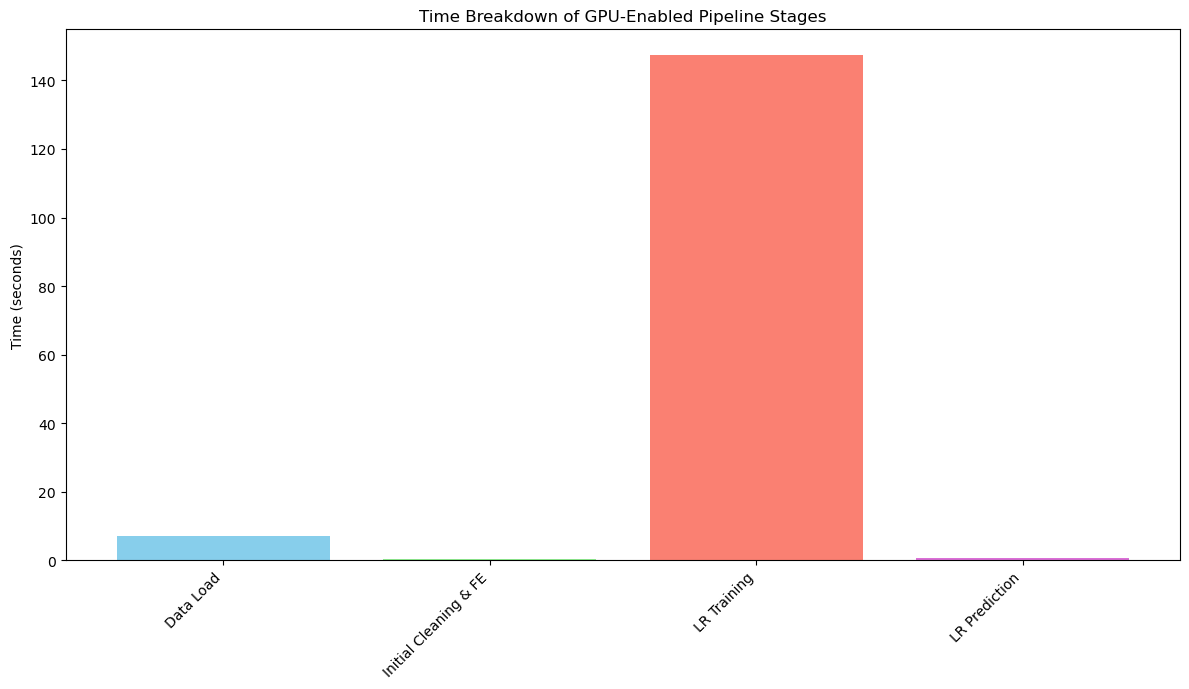

25/08/08 14:16:42 WARN GpuOverrides: 
!Exec <ProjectExec> cannot run on GPU because unsupported data types in input: org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7 [features#4988]; not all expressions can be replaced
  @Expression <AttributeReference> label#4734 could run on GPU
  @Expression <Alias> UDF(UDF(features#4988)) AS prediction#5080 could run on GPU
    !Expression <ScalaUDF> UDF(UDF(features#4988)) cannot run on GPU because neither UDF implemented by class org.apache.spark.ml.classification.ProbabilisticClassificationModel$$Lambda$5806/0x0000000801f50040 provides a GPU implementation, nor the conf `spark.rapids.sql.rowBasedUDF.enabled` is enabled; param expression ScalaUDF UDF(features#4988) (org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7 is not supported)
      !Expression <ScalaUDF> UDF(features#4988) cannot run on GPU because param expression AttributeReference features#4988 (org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7 is not supported); expression ScalaUDF UDF(features#4

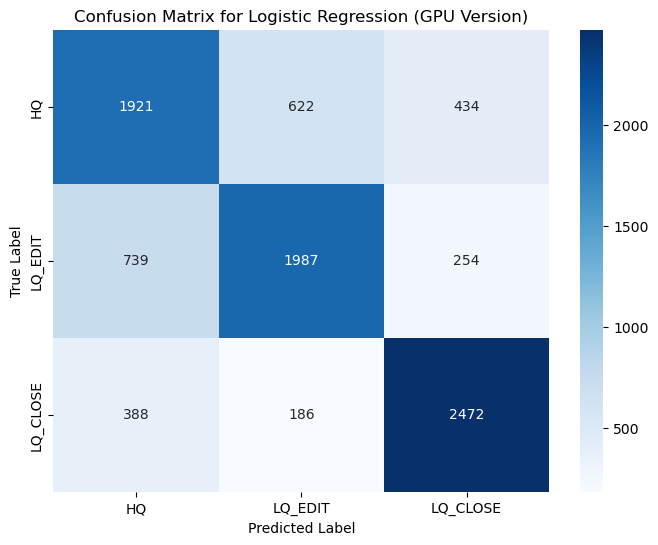

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np 

try:
    times_gpu = {
        "Data Load": load_time,
        "Initial Cleaning & FE": clean_feature_time,
        "LR Training": lr_train_time,
        "LR Prediction": lr_predict_time
    }

    labels_gpu = list(times_gpu.keys())
    values_gpu = list(times_gpu.values())

    plt.figure(figsize=(12, 7))
    plt.bar(labels_gpu, values_gpu, color=['skyblue', 'lightgreen', 'salmon', 'orchid'])
    plt.ylabel("Time (seconds)")
    plt.title("Time Breakdown of GPU-Enabled Pipeline Stages")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig("gpu_pipeline_time_breakdown_srai.png")
    plt.show()

except NameError:
    print("Time tracking variables not defined, skipping GPU time breakdown plot.")
except Exception as e:
    print(f"Error generating GPU time breakdown plot: {e}")
    traceback.print_exc()

try:
    predictions_pd = lr_predictions.select("label", "prediction").toPandas()
    cm = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])
    class_labels = ["HQ", "LQ_EDIT", "LQ_CLOSE"]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for Logistic Regression (GPU Version)")
    plt.savefig("gpu_confusion_matrix_lr_srai.png")
    plt.show()

except Exception as e:
    print(f"Error generating GPU confusion matrix plot: {e}")
    traceback.print_exc()


finally:
    try:
        if 'spark' in locals() and spark is not None:
            spark.stop()
    except Exception as e:
        print(f"Error stopping Spark session: {e}")
        traceback.print_exc()